 - We have a set of `true_label` and `pred_label` in a classification setting
 - Both labels belong to the Tasic et al. taxonomy 
 - We first create a reference distance matrix, for any pair of leaf node labels using the dendrogram
 - For any (`true_label`, `pred_label`) pair we now simply have to look up the value in the reference distance matrix
 - For perfect accuracy, the cophenetic distance is 0
 - The distance matrix is not normalized (i.e. the height of root node is not 1) - this can be imposed by dividing all entries in the reference matrix by the root node height

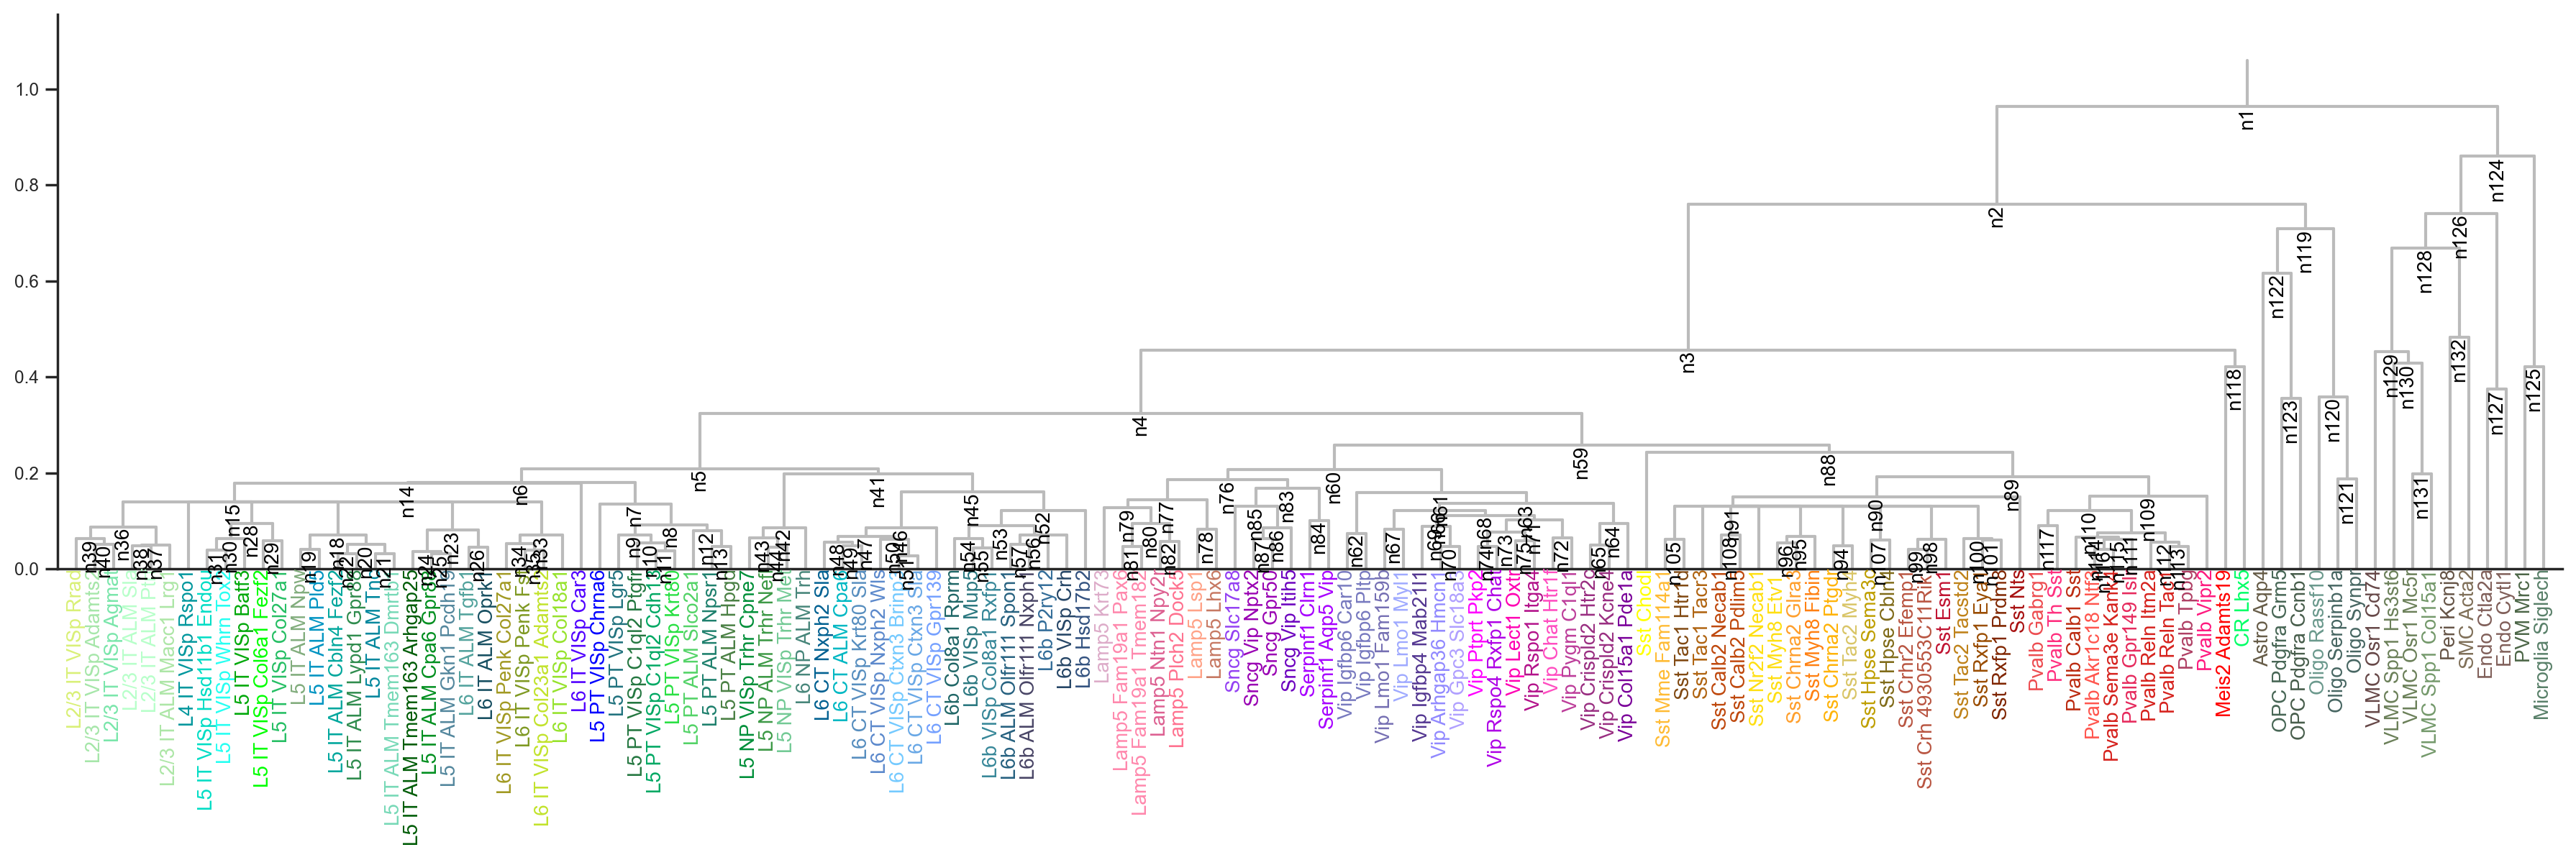

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from ctree.analysis_tree_helpers import HTree
from ctree.utils import get_path

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format="retina"


# Load a tree from the .csv file
htree = HTree(htree_file=get_path() + "/data/tree_20180520.csv")
htree.plot(figsize=(18, 5), fontsize=10)

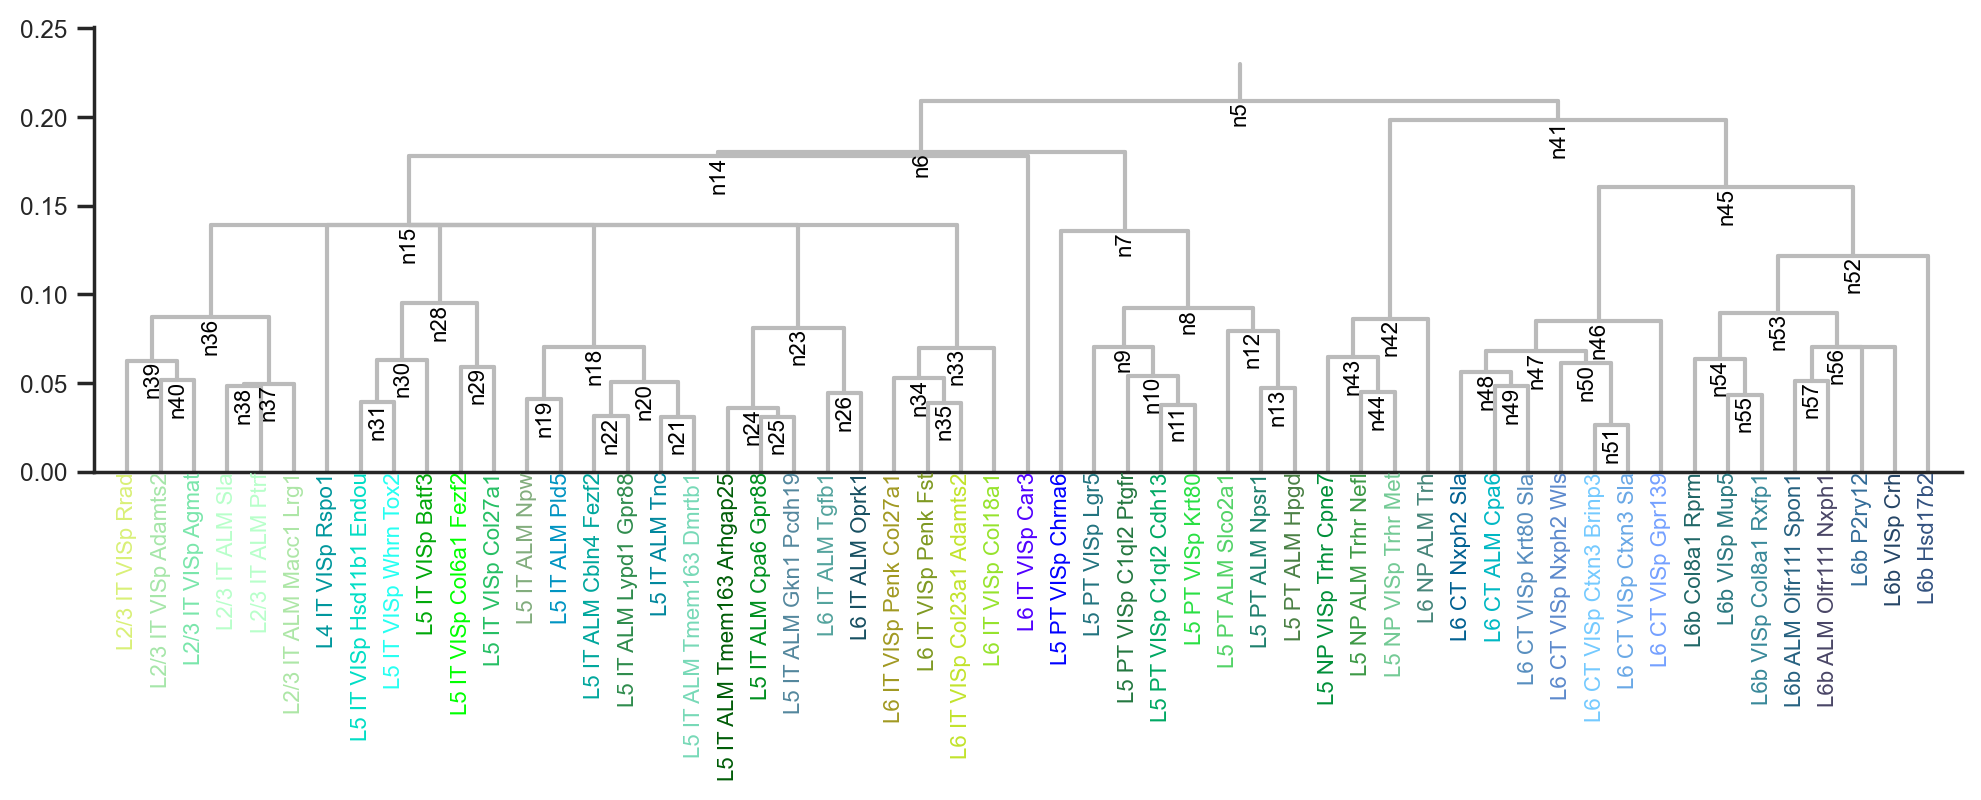

In [2]:
# subtree is a instance of class HTree as well. Here we will consider only excitatory cells (root node is n5)
subtree = htree.get_subtree(node="n5")
subtree.plot((10, 3), fontsize=8)

### Calculate common ancestor, and distance matrix based on height of dendrogram:
 - For an pair of leaf node labels, we first find the lowest common ancestor node as per the dendrogram
 - The height for this common ancestor is saved in the dataframe for further calculations

In [3]:
# get all leaf nodes for selected tree
subtree_df = subtree.obj2df()
leaf_list = subtree_df["child"].loc[subtree_df["isleaf"]].to_list()

# define empty dataframes to store results
df_distance = pd.DataFrame(np.zeros((len(leaf_list), len(leaf_list))), columns=leaf_list, index=leaf_list)

df_common_ancestor = pd.DataFrame(columns=leaf_list, index=leaf_list)

In [4]:
for li in leaf_list:
    for lj in leaf_list:
        ancestors_i = subtree.get_ancestors(node=li)
        ancestors_i.insert(0, li)

        ancestors_j = subtree.get_ancestors(node=lj)
        ancestors_j.insert(0, lj)

        found = False
        ancestors_i.reverse()
        while ancestors_i and (not found):
            this_node = ancestors_i.pop()
            if this_node in ancestors_j:
                found = True
                df_common_ancestor.loc[lj, li] = this_node
                df_distance.loc[lj, li] = subtree_df.loc[subtree_df["child"] == this_node, "y"].iloc[0]
                # df_distance.loc[lj,li] = subtree_df['y'][subtree_df['child']==this_node]

### Distance matrix to use for calculations:

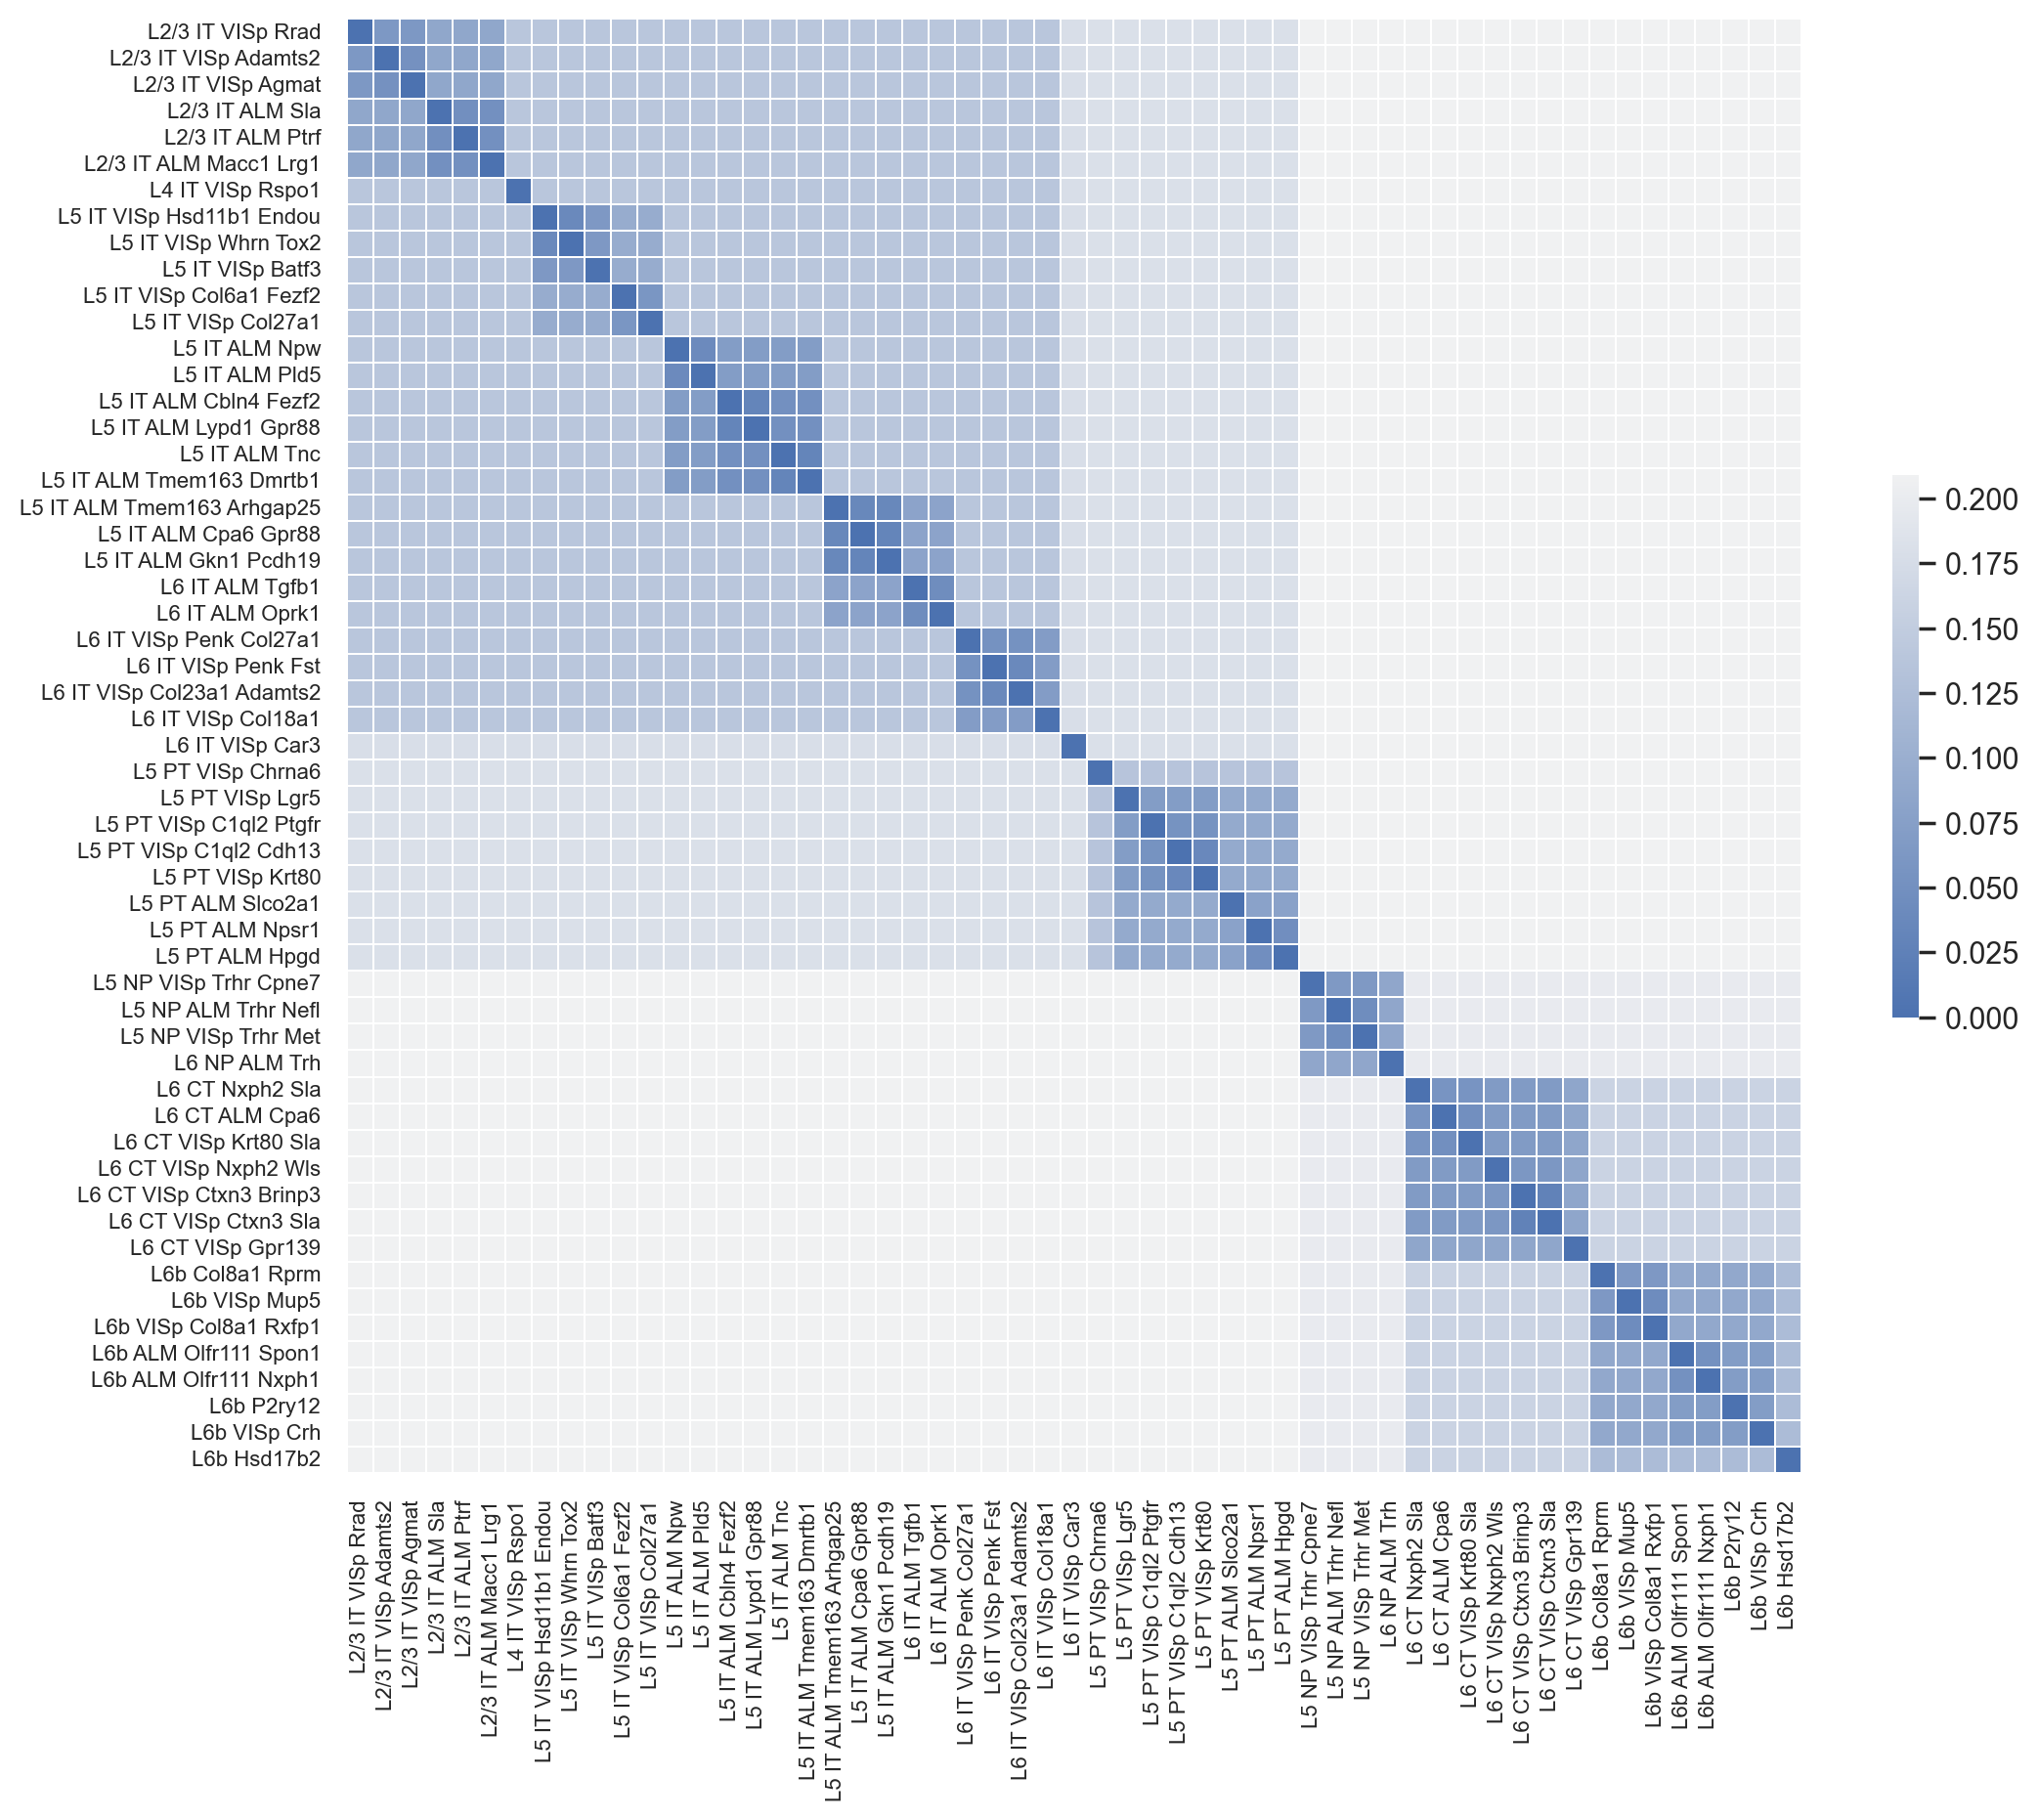

In [5]:
sns.set()
f, ax = plt.subplots(1, 1, figsize=(12, 12))
ax = sns.heatmap(
    df_distance,
    vmin=0,
    vmax=subtree_df["y"].max(),
    xticklabels=True,
    yticklabels=True,
    square=True,
    linewidths=0.1,
    cmap=sns.color_palette("light:b_r", as_cmap=True),
    cbar_kws={"shrink": 0.3, "orientation": "vertical"},
)
# set tick labels to be the same size
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
plt.show()

### Example calculation:

In [6]:
# Use df_distance_norm = df_distance/subtree_df['y'].max() if you want the normalized distance matrix here:
true_labels = ["L2/3 IT VISp Rrad", "L2/3 IT VISp Rrad", "L2/3 IT ALM Ptrf"]
pred_labels = ["L2/3 IT VISp Rrad", "L2/3 IT VISp Agmat", "L2/3 IT ALM Ptrf"]

cophenetic_distance = []
common_ancestor = []
for l_true, l_pred in zip(true_labels, pred_labels):
    cophenetic_distance.append(df_distance[l_true][l_pred])
    common_ancestor.append(df_common_ancestor[l_true][l_pred])

result = pd.DataFrame({
    "true_labels": true_labels,
    "pred_labels": pred_labels,
    "cophenetic_distance": cophenetic_distance,
    "common_ancestor": common_ancestor,
})
result

,true_labels,pred_labels,cophenetic_distance,common_ancestor
0,L2/3 IT VISp Rrad,L2/3 IT VISp Rrad,0.000000,L2/3 IT VISp Rrad
1,L2/3 IT VISp Rrad,L2/3 IT VISp Agmat,0.062546,n39
2,L2/3 IT ALM Ptrf,L2/3 IT ALM Ptrf,0.000000,L2/3 IT ALM Ptrf
